In [ ]:
import numpy as np
import os
import scipy.io as sio
import cv2
import math
from math import cos, sin
import dlib
import glob
from pathlib import Path
import pandas as pd
from PIL import Image, ImageFilter

In [ ]:
mylist = [Path(f).stem for f in glob.glob("/content/AFLW2000/*.mat")]

In [ ]:
def get_list_from_filenames(file_path):
  lines=[Path(f).stem for f in glob.glob(file_path)]
  return lines

In [ ]:
def get_pt2d_from_mat(mat_path):
    # Get 2D landmarks
    mat = sio.loadmat(mat_path)
    pt2d = mat['pt2d']
    return pt2d

In [ ]:
def get_pt3d_68_from_mat(mat_path):
   mat = sio.loadmat(mat_path)
   pt3d = mat['pt3d_68']
   pt3d=pt3d[:2,:]
   X=pt3d.flatten()
   return X


In [ ]:
!unzip /content/AFLW2000-3D.zip

Archive:  /content/AFLW2000-3D.zip
   creating: AFLW2000/
   creating: AFLW2000/Code/
  inflating: AFLW2000/Code/DrawSolidHead.m  
  inflating: AFLW2000/Code/DrawTextureHead.m  
  inflating: AFLW2000/Code/main_show_without_BFM.m  
  inflating: AFLW2000/Code/main_show_with_BFM.m  
   creating: AFLW2000/Code/Mex/
  inflating: AFLW2000/Code/Mex/compile.m  
  inflating: AFLW2000/Code/Mex/Tnorm_Vnorm.h  
  inflating: AFLW2000/Code/Mex/Tnorm_VnormC.cpp  
  inflating: AFLW2000/Code/Mex/Tnorm_VnormC.mexw64  
   creating: AFLW2000/Code/ModelGeneration/
  inflating: AFLW2000/Code/ModelGeneration/ModelGenerate.m  
  inflating: AFLW2000/Code/ModelGeneration/model_info.mat  
  inflating: AFLW2000/Code/Model_Exp.mat  
  inflating: AFLW2000/Code/Model_Shape_Sim.mat  
  inflating: AFLW2000/Code/NormDirection.m  
  inflating: AFLW2000/Code/readme.txt  
  inflating: AFLW2000/Code/RotationMatrix.m  
  inflating: AFLW2000/Code/Tnorm_VnormC.mexw64  
  inflating: AFLW2000/image00002.jpg  
  inflating: AFLW2

In [ ]:
x=get_pt3d_68_from_mat("/content/AFLW2000/image03639.mat")
x.shape


(136,)

In [ ]:
def get_ypr_from_mat(mat_path):
    # Get yaw, pitch, roll from .mat annotation.
    # They are in radians
    mat = sio.loadmat(mat_path)
    # [pitch yaw roll tdx tdy tdz scale_factor]
    pre_pose_params = mat['Pose_Para'][0]
    # Get [pitch, yaw, roll]
    pose_params = pre_pose_params[:3]
    return pose_params

In [ ]:
class AFLW2000():
    def __init__(self, data_dir,file_path, img_ext='.jpg', annot_ext='.mat', image_mode='RGB'):
        self.data_dir = data_dir
        self.file_path = file_path
        self.img_ext = img_ext
        self.annot_ext = annot_ext

        filename_list = get_list_from_filenames(data_dir)
        filename_list.sort()
        self.X_train = filename_list
        self.y_train = filename_list ####????????????
        self.image_mode = image_mode
        self.length = len(filename_list)

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.file_path,self.X_train[index] + self.img_ext))
        img = img.convert(self.image_mode)
        mat_path = os.path.join(self.file_path,self.y_train[index] + self.annot_ext)

        # Crop the face loosely
        pt2d = get_pt2d_from_mat(mat_path)

        x_min = min(pt2d[0,:])
        y_min = min(pt2d[1,:])
        x_max = max(pt2d[0,:])
        y_max = max(pt2d[1,:])

        k = 0.20
        x_min -= 2 * k * abs(x_max - x_min)
        y_min -= 2 * k * abs(y_max - y_min)
        x_max += 2 * k * abs(x_max - x_min)
        y_max += 0.6 * k * abs(y_max - y_min)
        img = img.crop((int(x_min), int(y_min), int(x_max), int(y_max)))

        # We get the pose in radians
        pose = get_ypr_from_mat(mat_path)
        # And convert to degrees.
        pitch = pose[0] * 180 / np.pi
        yaw = pose[1] * 180 / np.pi
        roll = pose[2] * 180 / np.pi
        # Bin values
        bins = np.array(range(-99, 102, 3))
        labels =np.digitize([yaw, pitch, roll], bins) - 1
        cont_labels = [yaw, pitch, roll]
          
        #pt_3d_68
        pt_3d=get_pt3d_68_from_mat(mat_path)

        # if self.transform is not None:
        #     img = self.transform(img)
        # return cont_labels
        return img, labels, cont_labels, self.X_train[index],pt_3d

    def __len__(self):
        # 2,000
        return self.length


In [ ]:
demo=AFLW2000("/content/AFLW2000/*.mat",'/content/AFLW2000/')

In [ ]:
demo.__getitem__(0)

(<PIL.Image.Image image mode=RGB size=628x427 at 0x7FB28D3B7DD0>,
 array([33, 25, 34]),
 [1.044306042017331, -22.874238643575588, 4.908885557905314],
 'image00002',
 array([121.868034, 122.36761 , 126.81924 , 130.83179 , 137.52313 ,
        148.52173 , 161.52802 , 182.87668 , 213.94006 , 248.00537 ,
        274.67615 , 293.22473 , 309.20724 , 321.27457 , 329.8783  ,
        339.07126 , 345.24066 , 144.61288 , 158.1359  , 175.37297 ,
        191.31126 , 205.48387 , 261.70496 , 277.2635  , 294.11136 ,
        311.59164 , 323.95364 , 231.0957  , 229.7904  , 227.30476 ,
        225.08842 , 202.42142 , 210.7933  , 222.43806 , 235.00792 ,
        244.54094 , 162.57912 , 173.47615 , 188.50098 , 201.39299 ,
        188.09201 , 172.65819 , 260.8649  , 275.8604  , 291.34073 ,
        301.85168 , 289.989   , 273.8536  , 180.50743 , 192.32265 ,
        209.19904 , 218.46085 , 228.46553 , 248.99286 , 261.81235 ,
        243.97612 , 228.25139 , 212.72568 , 199.55211 , 189.6707  ,
        183.1438  ,

In [ ]:
features=[]
labels=[]
imgs=[]
features_68=[]

for i in range(2000):
  features.append(demo.__getitem__(i)[1])
  x = np.array(demo.__getitem__(i)[2], dtype=np.float32)
  labels.append(x)
  imgs.append(demo.__getitem__(i)[3])
  features_68.append(demo.__getitem__(i)[4])

## generate features from 2d points

In [ ]:
points_features=pd.DataFrame(features_68)



In [ ]:
labels = np.array(labels, dtype=np.float32)
labels_df=pd.DataFrame(labels,columns=['yaw','pitch','roll'])

In [ ]:
data_train=pd.concat([points_features,labels_df],axis=1)

In [ ]:
data_train.head()

,0,1,2,3,4,5,6,7,8,9,...,129,130,131,132,133,134,135,yaw,pitch,roll
0,121.868034,122.367607,126.819237,130.831787,137.523132,148.521729,161.528015,182.876678,213.940063,248.005371,...,310.149048,313.233856,315.107117,322.384613,330.965576,330.701965,324.903870,1.044306,-22.874239,4.908885
1,281.238159,277.339417,274.876953,269.523773,257.788269,240.968155,221.801483,205.846298,207.085449,226.185638,...,303.093811,300.724457,300.060974,303.260895,299.485168,300.598602,302.286499,68.155243,26.932743,17.243670
2,236.385101,239.198257,242.566376,243.971375,242.828186,238.567902,232.561859,229.155289,238.303162,259.122467,...,303.122009,302.877289,302.146454,300.489380,303.481873,304.681732,304.631042,50.485413,-10.579652,-13.570645
3,168.029221,177.697510,190.641602,201.395294,211.957214,222.723099,231.350220,244.332855,268.327637,291.832214,...,315.469391,312.701294,310.133301,300.041290,315.544800,319.498596,320.843994,17.143373,-10.048455,-21.392782
4,280.462250,287.249817,293.892456,297.539368,295.677002,287.270355,271.661591,254.701157,250.219299,261.212463,...,306.811768,307.014893,305.351318,309.934814,311.558899,312.920746,312.058350,68.640549,-50.544582,-59.207973


## Train_Test_split

In [ ]:
y=data_train[['yaw','pitch','roll']]
X=data_train.drop(columns=['yaw','pitch','roll'],axis=1)

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

## Construct Model

In [ ]:
from sklearn.multioutput import MultiOutputClassifier,MultiOutputRegressor
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
multi_target_reg = MultiOutputRegressor(RandomForestRegressor(), n_jobs=2)
multi_target_reg.fit(X, y)

MultiOutputRegressor(estimator=RandomForestRegressor(), n_jobs=2)

In [ ]:
predictions=multi_target_reg.predict(X_test)
predictions

array([[-41.31358055, -19.42150781,   2.06741664],
       [ 33.26583757,   0.40197809,   2.85129952],
       [ -1.79847448,   9.56129509, -35.51814329],
       ...,
       [ 11.56098224, -16.01967399,  10.14670492],
       [  8.83182183, -11.19774909, -13.98732742],
       [-24.40144899,  18.2007497 , -21.73856473]])

In [ ]:
multi_target_reg.score(X_test, y_test, sample_weight=None)

0.8732491463181677

In [ ]:
from google.colab.patches import cv2_imshow

In [ ]:
def draw_axis(img, yaw, pitch, roll, tdx=None, tdy=None, size = 100):

    pitch = pitch * np.pi / 180
    yaw = -(yaw * np.pi / 180)
    roll = roll * np.pi / 180

    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img


In [ ]:
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2

--2022-05-14 13:19:40--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  5.63MB/s    in 12s     

2022-05-14 13:19:52 (5.14 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]



In [ ]:
!wget http://arunponnusamy.com/files/mmod_human_face_detector.dat

--2022-05-14 13:19:53--  http://arunponnusamy.com/files/mmod_human_face_detector.dat
Resolving arunponnusamy.com (arunponnusamy.com)... 185.199.109.153, 185.199.110.153, 185.199.111.153, ...
Connecting to arunponnusamy.com (arunponnusamy.com)|185.199.109.153|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.arunponnusamy.com/files/mmod_human_face_detector.dat [following]
--2022-05-14 13:19:53--  https://www.arunponnusamy.com/files/mmod_human_face_detector.dat
Resolving www.arunponnusamy.com (www.arunponnusamy.com)... 185.199.111.153, 185.199.109.153, 185.199.108.153, ...
Connecting to www.arunponnusamy.com (www.arunponnusamy.com)|185.199.111.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 729940 (713K) [application/octet-stream]
Saving to: ‘mmod_human_face_detector.dat’

mmod_human_face_det 100%[===================>] 712.83K  --.-KB/s    in 0.03s   

2022-05-14 13:19:53 (24.1 MB/s) - ‘mmod_human_face_dete

In [ ]:
!bzip2 -d  '/content/shape_predictor_68_face_landmarks.dat.bz2'

In [ ]:
predictor=dlib.shape_predictor('/content/shape_predictor_68_face_landmarks.dat')
cnn_face_detector = dlib.get_frontal_face_detector()

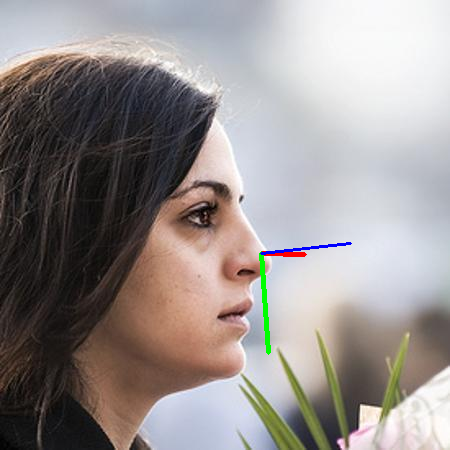

In [ ]:
image='/content/AFLW2000/image04153.jpg'
frame = cv2.imread(image)

cv2_frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)

dets = cnn_face_detector(cv2_frame, 1)
for (idx, det) in enumerate(dets):
            # Get x_min, y_min, x_max, y_max, conf
            x_min = det.left()
            y_min = det.top()
            x_max = det.right()-x_min
            y_max = det.bottom()-y_min
            # conf = det.confidence
            # print(det)

            shape = predictor(cv2_frame, det)
            tdx,tdy=shape.part(30).x, shape.part(30).y
            bbox_height, bbox_width = frame.shape[:2]
           
            cv2.destroyAllWindows()
            cv2_imshow(draw_axis(frame,-64,12 ,-10,tdx,tdy)
            )
cv2.destroyAllWindows()

## Generate landmarks dlib

In [ ]:
def generate_landmarks(path):
      image=path
      img = cv2.imread( image)
      img=cv2.resize(img,(512,512))
      img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      mask = np.zeros_like(img_gray)
      detector = dlib.get_frontal_face_detector()
      predictor = dlib.shape_predictor('/content/shape_predictor_68_face_landmarks.dat')
      # Face 1
      faces = detector(img_gray)
      for face in faces:
          landmarks = predictor(img_gray, face)
          landmarks_points = []
          landmarks_points_x = []
          landmarks_points_y = []
          for n in range(0,68):
              x = landmarks.part(n).x
              y = landmarks.part(n).y
              landmarks_points_x.append(x)
              landmarks_points_y.append(y)
              cv2.circle(img_gray, (x,y), radius=0, color=(0,0,0), thickness=5)
          cv2_imshow(img_gray)
          cv2.destroyAllWindows()
      landmarks_points=landmarks_points_x+landmarks_points_y
      return landmarks_points

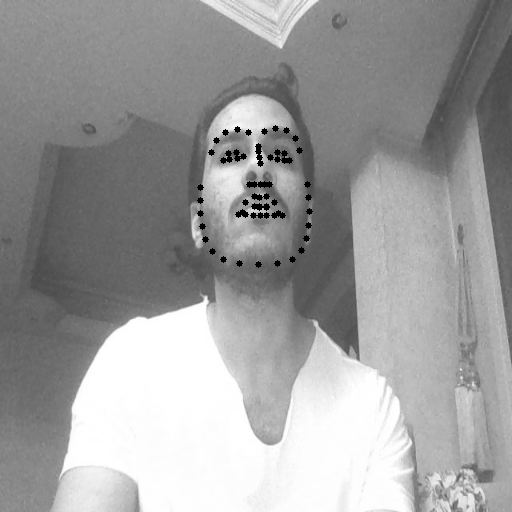

In [ ]:
landmarks_points=generate_landmarks('/content/Honda2.png')

In [ ]:
landmarks_points=np.array(landmarks_points)

In [ ]:
multi_target_reg.predict(landmarks_points.reshape(1, -1))

array([[  -2.33418729,  153.63127663, -145.21302409]])

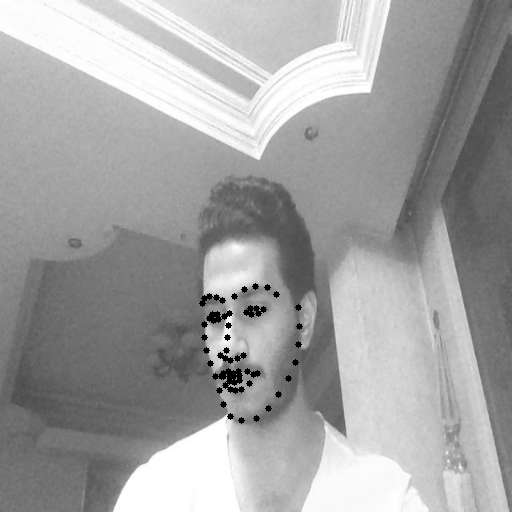

In [ ]:
landmarks_points=generate_landmarks('/content/Honda4.png')

In [ ]:
landmarks_points=np.array(landmarks_points)

In [ ]:
multi_target_reg.predict(landmarks_points.reshape(1, -1))

array([[  13.21532088,   15.53754661, -129.60774247]])

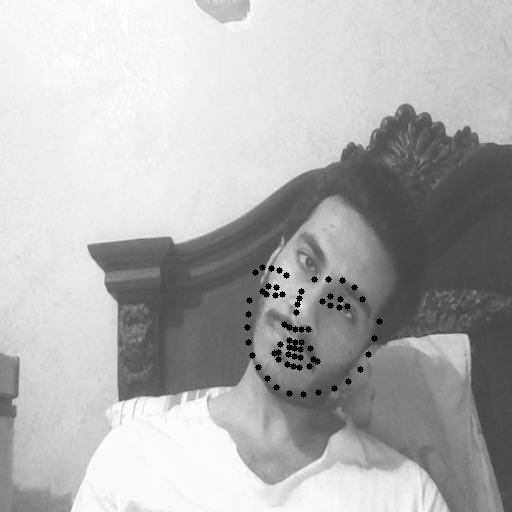

In [ ]:
landmarks_points=generate_landmarks('/content/Honda7.png')

In [ ]:
landmarks_points=np.array(landmarks_points)

In [ ]:
multi_target_reg.predict(landmarks_points.reshape(1, -1))

array([[  14.17030798,   -6.41184136, -102.60765004]])

In [ ]:
landmarks_points=np.array(landmarks_points)